In [2]:
import os 
import pandas as pd
from elasticsearch import Elasticsearch 

In [3]:
from src.utils.general import get_db_conn

In [4]:
creds_folder = '../conf/local/'
fpath = os.path.join(creds_folder, 'credentials.yaml')
db_con = get_db_conn(fpath)

In [5]:
es = Elasticsearch([{'host':'localhost','port':9200}])

### Notes

Bill status and text types are two different things, bill status is what state the bill is in. For older bills, we only have the last entry. Ideally, the `bills` table should have different entries to see how the bill changes with time. 

A bill document/version can be mainly in four different stages

- Introduced: The bill in the form that it was introduced. 
- Amemded: Added an amendment to the introduced format
- Engrossed: Once amended and offical copy of the bill. Approved amendments are adopted.
- Enrolled: Once the votes are obtained to pass from both bodies, the text has been put in its final form to be sent to the governener

So, the enrolled version is sent to the governer, and the governer can veto it or accept it. 

### Status changes that a bill goes through

In [6]:
q = """
select 
    bill_id,
    max(state_id) as state_id, 
    max(a.status) as status, 
    max(a.status_date) as status_date,
    max(a.bill_type) as bill_type,
    array_agg(b.doc_type) as doc_types,
    array_agg(b.doc_id) as doc_ids
from raw.bills a left join raw.bill_docs b using (bill_id) 
group by bill_id;
"""

bill_doc_statuses = pd.read_sql(q, db_con)

In [6]:
# bill_doc_statuses.head()

In [7]:
num_versions = bill_doc_statuses['doc_ids'].apply(lambda x: len(x)) 

In [8]:
num_versions.min()

1

#### Note:

Resolutions tend to get passed without much ammending

In [9]:
res_msk = (bill_doc_statuses['bill_type'] == 'R')

In [11]:
# bill_doc_statuses[res_msk].head(20)

In [12]:
# bill_doc_statuses[~res_msk].head(20)

<AxesSubplot:>

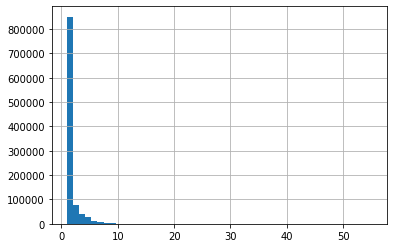

In [14]:
num_versions[~res_msk].hist(bins=50)

#### WHen there's only one version, whats the status

In [19]:
version_msk = (num_versions == 1)

<AxesSubplot:>

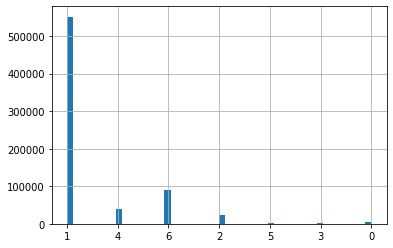

In [20]:
bill_doc_statuses[~res_msk & version_msk]['status'].hist(bins=50)

#### Events

In [24]:
q = """
    select 
        bill_id, 
        event_date, 
        action
        from raw.bill_events 
        where extract(year from event_date) <= 2018 order by event_date desc;
"""

bill_events = pd.read_sql(q, db_con)

In [25]:
event_counts = bill_events.groupby('bill_id', as_index=False).count()[['bill_id', 'action']]
event_counts.rename(columns={'action': 'num_events'}, inplace=True)

In [26]:
event_counts['num_events'].idxmax()

179451

In [9]:
# event_counts.iloc[355484]

In [10]:
# msk = bill_doc_statuses['bill_id'] == '36641' 

# bill_doc_statuses[msk]

In [11]:
# bill_events.head()

In [12]:
# bill_events.sort_values('event_date', ascending=False)

In [13]:
# event_counts.head()

In [14]:
# msk = bill_events['bill_id'] == '1000001'
# bill_events[msk].sort_values('event_date')

In [15]:
# bill_doc_statuses[bill_doc_statuses['bill_id'] == '1000001']

In [16]:
# bill_doc_statuses[bill_doc_statuses['status']=='4']

In [1]:
# msk = bill_events['bill_id'] == '1000008'
# bill_events[msk]['event_date'].max() -  bill_events[msk]['event_date'].min()

#### Number of days the bill stayed active

In [74]:
def get_dayrange(df):
    date_range = df['event_date'].max() - df['event_date'].min()
    
    return date_range.days

durations = bill_events.groupby('bill_id').apply(get_dayrange)
# durations = bill_events[:200].groupby('bill_id').count()

(0.0, 2000.0)

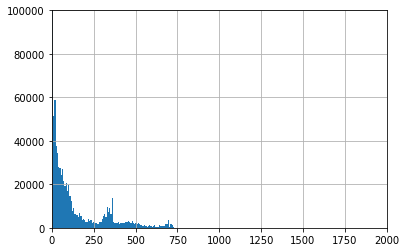

In [90]:
ax = durations.hist(bins=2000)
ax.set_ylim(0, 100000)
ax.set_xlim(0, 2000)

(0.0, 100.0)

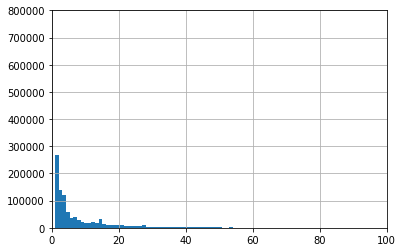

In [100]:
ax = event_counts['num_events'].hist(bins=1000)
ax.set_ylim(0, 800000)
ax.set_xlim(0, 100)

### Passed bills percentage

In [104]:
passed_msk = bill_doc_statuses['status']=='4'
passed_recs = bill_doc_statuses[passed_msk].shape[0]
tot_recs = bill_doc_statuses.shape[0]

In [105]:
passed_recs/tot_recs

0.26946882558140534

#### Yearly

In [17]:
# bill_events.groupby('bill_id').apply(lambda x: x['event_date'].min())